In [1]:
# # 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('F:/hk2 nam3/nhi/is403/IS403_O21_04/Dataset/DIG Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[::-1]
df1=df.reset_index()['Price']
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1593    27350.0
1594    27850.0
1595    27950.0
1596    27600.0
1597    27750.0
Name: Price, Length: 1598, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
test_size

320

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)



In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
X_train.shape

(1177, 100, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - loss: 0.0309 - val_loss: 0.0011
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.0041 - val_loss: 7.5953e-04
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - loss: 0.0027 - val_loss: 6.5144e-04
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - loss: 0.0032 - val_loss: 9.6169e-04
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - loss: 0.0028 - val_loss: 4.8825e-04
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - loss: 0.0020 - val_loss: 4.5500e-04
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - loss: 0.0016 - val_loss: 3.7003e-04
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - loss: 0.0013 - val_loss: 5.0598e-04
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - loss: 0.0011 - val_loss: 3.4121e-04
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - loss: 0.0011 - val_loss: 3.5033e-04
Epoch

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
y_pred.shape

(219, 1)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
test_mae = np.mean(np.abs(ytest - y_pred))


print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 26835.35545238754
Testing MAPE: 12448143.934378458
Testing MAE: 26681.70234562952


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[:100].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.15814355]
101
1 day input [0.0950626  0.08414615 0.08360033 0.07868793 0.07213806 0.075413
 0.06558819 0.06558819 0.05630921 0.06504237 0.0584925  0.06122162
 0.06012997 0.05685504 0.05467175 0.04812188 0.05630921 0.05903833
 0.06395073 0.05576339 0.05958415 0.06176744 0.06449655 0.06722566
 0.07268388 0.06886313 0.07159224 0.06886313 0.075413   0.0852378
 0.09069602 0.09724589 0.10161247 0.11362056 0.11798714 0.11907878
 0.11580385 0.11798714 0.1048874  0.10597905 0.11798714 0.11362056
 0.11525803 0.1147122  0.11252891 0.1048874  0.11252891 0.11907878
 0.13217852 0.13436181 0.13599928 0.13381599 0.12999523 0.13709092
 0.1512823  0.15346559 0.14855319 0.15728635 0.15510306 0.13927421
 0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.

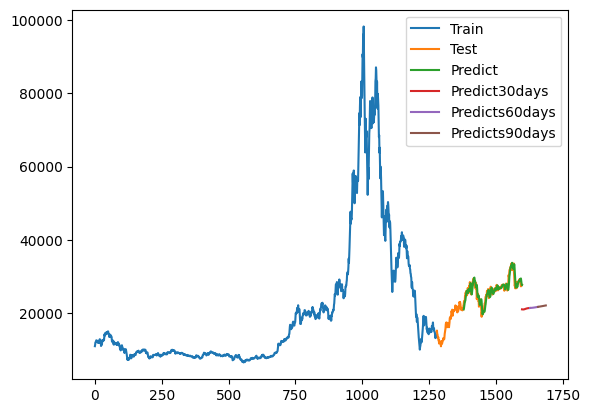

In [19]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output[0:30]))
predict_data_index_60 = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output[30:60]))
predict_data_index_90 = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predicts60days', 'Predicts90days'])
plt.savefig('Team4_LSTM_DIG_8_2.png')
plt.show()
